# Synthetische Daten Evaluation: LLM vs. GAN Generierung

## Executive Summary

Dieses Notebook vergleicht die Qualität und Eignung von synthetischen Datensätzen, die mit zwei verschiedenen Ansätzen generiert wurden:
- **LLM-basierte Generierung**: Verwendung von Large Language Models
- **GAN-basierte Generierung**: Verwendung von Generative Adversarial Networks

**Ziel**: Evaluation der synthetischen Datenqualität für das Training neuronaler Netze zur Bierempfehlung.

---

## 1. Setup und Datenimport

Nach der Analyse Ihres Notebooks sehe ich, dass bereits eine sehr umfangreiche univariate Analyse vorliegt, aber folgende Bereiche der ursprünglich vorgeschlagenen 8-Punkte-Gliederung noch fehlen oder unvollständig sind:

## Fehlende Hauptbereiche:

### 1. **Data Overview & Quality Check** (Punkt 1 der Gliederung)
- Grundlegende Datensatz-Exploration am Anfang
- Systematische Datentyp-Analyse
- Vollständige Missing-Value-Patterns
- Datensatz-Metadaten und Strukturübersicht

### 2. **Consumer Behavior Patterns** (Punkt 3 der Gliederung)
- Integration der einzelnen Analysen zu übergreifenden Verhaltensmustern
- Segmentierung basierend auf Q1 (Konsumhäufigkeit)
- Cross-Analyse zwischen Konsumverhalten (Q1) und Trinksituationen (Q4)
- Zusammenhang zwischen Biersorten-Präferenzen (Q2) und Konsumfrequenz

### 3. **Attitudes & Involvement** (Punkt 4 der Gliederung)
- Kombinierte Analyse von Q6 (Einstellungen) und Q7 (Entscheidungsfaktoren)
- Involvement-Skala Entwicklung
- Einstellungs-Cluster

### 4. **Consumer Segmentation** (Punkt 7 der Gliederung)
- Clusteranalyse fehlt komplett
- PCA/Faktoranalyse
- Konsumententypen-Entwicklung
- Personas/Zielgruppen-Profile

### 5. **Key Insights & Recommendations** (Punkt 8 der Gliederung)
- Strategische Zusammenfassung
- Handlungsempfehlungen für das Business
- Priorisierung der Erkenntnisse
- Managementsummary

## Verbesserungsbedarf bei vorhandenen Bereichen:

### **Correlation & Relationship Analysis** (unvollständig)
- Aktuell nur interne Korrelationen pro Fragengruppe
- Cross-Gruppen-Korrelationen fehlen weitgehend
- Interpretative Analyse der Zusammenhänge

### **Visualisierungen**
- Weniger umfangreiche Plots für bessere Agent-Mode-Kompatibilität
- Mehr zusammenfassende Charts statt Einzelanalysen
- Dashboard-artige Übersichtsvisualisierungen

## Strukturelle Verbesserungen:

1. **Logische Reihenfolge**: Vom Allgemeinen zum Spezifischen
2. **Integration**: Einzelanalysen zu Gesamtbildern verbinden
3. **Business-Fokus**: Mehr praktische Implikationen
4. **Kompaktheit**: Weniger Output pro Zelle für Agent-Mode

Das Notebook hat eine exzellente technische Tiefe, aber es fehlt die strategische Ebene und die Synthese der Einzelerkenntnisse zu einem Gesamtbild des Konsumentenverhaltens.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Statistical tests
from scipy import stats
from scipy.stats import ks_2samp, chi2_contingency
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("📊 Synthetic Data Comparison Analysis - Setup Complete")

📊 Synthetic Data Comparison Analysis - Setup Complete


### 1.1 Datenimport

In [2]:
# Load datasets
try:
    # Original clean data - adjusted path from src/eda/ perspective
    df_original = pd.read_csv('../../clean_data.csv')
    
    # Synthetic datasets - correct paths to your actual files
    df_llm = pd.read_csv('../llm/synthetic_survey_data_NoNaNs_100.csv')
    df_gan = pd.read_csv('../gan/synthetic_data.csv')
    
    print("✅ All datasets loaded successfully")
    print(f"Original shape: {df_original.shape}")
    print(f"LLM synthetic shape: {df_llm.shape}")
    print(f"GAN synthetic shape: {df_gan.shape}")
    
except FileNotFoundError as e:
    print(f"❌ File not found: {e}")
    print("Please ensure all datasets are in the correct location")
    print("\nExpected file structure:")
    print("├── clean_data.csv")
    print("├── src/")
    print("│   ├── eda/synthetic_data_comparison.ipynb")
    print("│   ├── llm/synthetic_survey_data_NoNaNs_100.csv")
    print("│   └── gan/synthetic_data.csv")

✅ All datasets loaded successfully
Original shape: (488, 83)
LLM synthetic shape: (500, 83)
GAN synthetic shape: (500, 83)


## 2. Datensatz-Übersicht und Qualitätsprüfung

In [3]:
def dataset_overview(df, name):
    """Generate comprehensive overview of dataset characteristics"""
    
    overview = {
        'Dataset': name,
        'Rows': df.shape[0],
        'Columns': df.shape[1],
        'Missing Values': df.isnull().sum().sum(),
        'Missing %': round((df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100, 2),
        'Duplicate Rows': df.duplicated().sum(),
        'Memory Usage (MB)': round(df.memory_usage(deep=True).sum() / 1024**2, 2)
    }
    
    return overview

# Generate overview for all datasets
datasets = {
    'Original': df_original,
    'LLM Synthetic': df_llm,
    'GAN Synthetic': df_gan
}

overview_data = []
for name, df in datasets.items():
    overview_data.append(dataset_overview(df, name))

overview_df = pd.DataFrame(overview_data)
print("📋 Dataset Overview Comparison")
print("=" * 50)
display(overview_df)

📋 Dataset Overview Comparison


,Dataset,Rows,Columns,Missing Values,Missing %,Duplicate Rows,Memory Usage (MB)
0,Original,488,83,2958,7.3,0,0.31
1,LLM Synthetic,500,83,0,0.0,0,0.32
2,GAN Synthetic,500,83,0,0.0,0,0.32


### 2.1 Datenstruktur Vergleich

In [4]:
def compare_data_types(datasets_dict):
    """Compare data types across datasets"""
    
    comparison = {}
    
    # Get column names from original dataset as reference
    original_cols = list(datasets_dict['Original'].columns)
    
    for name, df in datasets_dict.items():
        comparison[name] = {
            'columns': list(df.columns),
            'dtypes': df.dtypes.astype(str).to_dict(),
            'missing_cols': set(original_cols) - set(df.columns),
            'extra_cols': set(df.columns) - set(original_cols)
        }
    
    return comparison

# Compare data structure
structure_comparison = compare_data_types(datasets)

print("🔍 Data Structure Analysis")
print("=" * 30)

for name, info in structure_comparison.items():
    print(f"\n{name}:")
    print(f"  Columns: {len(info['columns'])}")
    
    if info['missing_cols']:
        print(f"  Missing columns: {info['missing_cols']}")
    if info['extra_cols']:
        print(f"  Extra columns: {info['extra_cols']}")
    
    if name != 'Original':
        print(f"  Structure match: {'✅' if not info['missing_cols'] and not info['extra_cols'] else '❌'}")

🔍 Data Structure Analysis

Original:
  Columns: 83

LLM Synthetic:
  Columns: 83
  Structure match: ✅

GAN Synthetic:
  Columns: 83
  Structure match: ✅


### 2.2 Datenbereich und Werte-Validierung

In [5]:
def validate_data_ranges(df_orig, df_synth, dataset_name):
    """Validate if synthetic data stays within original data ranges"""
    
    validation_results = []
    
    # Get common columns
    common_cols = set(df_orig.columns) & set(df_synth.columns)
    
    for col in common_cols:
        if df_orig[col].dtype in ['int64', 'float64'] and df_synth[col].dtype in ['int64', 'float64']:
            orig_min, orig_max = df_orig[col].min(), df_orig[col].max()
            synth_min, synth_max = df_synth[col].min(), df_synth[col].max()
            
            # Check if synthetic data is within original bounds
            within_bounds = (synth_min >= orig_min) and (synth_max <= orig_max)
            
            validation_results.append({
                'Column': col,
                'Original_Min': orig_min,
                'Original_Max': orig_max,
                'Synthetic_Min': synth_min,
                'Synthetic_Max': synth_max,
                'Within_Bounds': within_bounds,
                'Min_Violation': synth_min < orig_min,
                'Max_Violation': synth_max > orig_max
            })
    
    validation_df = pd.DataFrame(validation_results)
    
    print(f"\n📊 Range Validation - {dataset_name}")
    print("=" * 40)
    
    violations = validation_df[~validation_df['Within_Bounds']]
    if len(violations) > 0:
        print(f"❌ Found {len(violations)} columns with range violations:")
        for _, row in violations.iterrows():
            print(f"  {row['Column']}: Original [{row['Original_Min']}, {row['Original_Max']}] vs Synthetic [{row['Synthetic_Min']}, {row['Synthetic_Max']}]")
    else:
        print("✅ All columns within original data ranges")
    
    return validation_df

# Validate both synthetic datasets
llm_validation = validate_data_ranges(df_original, df_llm, "LLM Synthetic")
gan_validation = validate_data_ranges(df_original, df_gan, "GAN Synthetic")


📊 Range Validation - LLM Synthetic
✅ All columns within original data ranges

📊 Range Validation - GAN Synthetic
✅ All columns within original data ranges


## 3. Statistische Verteilungsvergleiche

### 3.1 Kontinuierliche Variablen - Dichtevergleich

In [ ]:
def compare_distributions_statistical(df_orig, df_llm, df_gan, sample_cols=None):
    """Statistical comparison of distributions using KS-test"""
    
    # Get numeric columns
    numeric_cols = df_orig.select_dtypes(include=[np.number]).columns.tolist()
    
    if sample_cols:
        numeric_cols = [col for col in numeric_cols if col in sample_cols]
    else:
        # Sample first 10 columns for initial analysis
        numeric_cols = numeric_cols[:10]
    
    results = []
    
    for col in numeric_cols:
        if col in df_llm.columns and col in df_gan.columns:
            # Remove NaN values
            orig_data = df_orig[col].dropna()
            llm_data = df_llm[col].dropna()
            gan_data = df_gan[col].dropna()
            
            # KS-tests
            ks_llm = ks_2samp(orig_data, llm_data)
            ks_gan = ks_2samp(orig_data, gan_data)
            
            results.append({
                'Column': col,
                'LLM_KS_Statistic': round(ks_llm.statistic, 4),
                'LLM_p_value': round(ks_llm.pvalue, 4),
                'LLM_Similar': ks_llm.pvalue > 0.05,
                'GAN_KS_Statistic': round(ks_gan.statistic, 4),
                'GAN_p_value': round(ks_gan.pvalue, 4),
                'GAN_Similar': ks_gan.pvalue > 0.05
            })
    
    results_df = pd.DataFrame(results)
    
    print("📈 Statistical Distribution Comparison (Kolmogorov-Smirnov Test)")
    print("=" * 65)
    print("Lower KS statistic = more similar distributions")
    print("p-value > 0.05 = distributions not significantly different\n")
    
    display(results_df)
    
    # Summary
    llm_similar = results_df['LLM_Similar'].sum()
    gan_similar = results_df['GAN_Similar'].sum()
    total = len(results_df)
    
    # Quality rating function
    def get_quality_rating(similar_pct):
        """Determine quality rating based on percentage of similar distributions"""
        if similar_pct >= 80:
            return "Excellent (Sehr gut)", "🟢"
        elif similar_pct >= 60:
            return "Good (Gut)", "🟡"  
        elif similar_pct >= 40:
            return "Acceptable (Akzeptabel)", "🟠"
        elif similar_pct >= 20:
            return "Poor (Schlecht)", "🔴"
        else:
            return "Critical (Kritisch)", "⚠️"
    
    llm_pct = llm_similar/total*100
    gan_pct = gan_similar/total*100
    
    llm_rating, llm_icon = get_quality_rating(llm_pct)
    gan_rating, gan_icon = get_quality_rating(gan_pct)
    
    print(f"\n📊 Summary:")
    print(f"LLM: {llm_similar}/{total} ({llm_pct:.1f}%) distributions similar to original")
    print(f"GAN: {gan_similar}/{total} ({gan_pct:.1f}%) distributions similar to original")
    
    print(f"\n🎯 Quality Assessment:")
    print("=" * 30)
    print(f"LLM Synthetic Data: {llm_icon} {llm_rating}")
    print(f"GAN Synthetic Data: {gan_icon} {gan_rating}")
    
    print(f"\n📋 Quality Scale:")
    print("  🟢 Excellent (Sehr gut):    >80% similar distributions")
    print("  🟡 Good (Gut):             60-80% similar distributions") 
    print("  🟠 Acceptable (Akzeptabel): 40-60% similar distributions")
    print("  🔴 Poor (Schlecht):        20-40% similar distributions")
    print("  ⚠️  Critical (Kritisch):    <20% similar distributions")
    
    # Add quality metrics to results
    quality_summary = {
        'llm_quality_rating': llm_rating,
        'gan_quality_rating': gan_rating,
        'llm_quality_pct': llm_pct,
        'gan_quality_pct': gan_pct
    }
    
    return results_df, quality_summary

# Run statistical comparison
distribution_comparison, quality_metrics = compare_distributions_statistical(df_original, df_llm, df_gan)

📈 Statistical Distribution Comparison (Kolmogorov-Smirnov Test)
Lower KS statistic = more similar distributions
p-value > 0.05 = distributions not significantly different



,Column,LLM_KS_Statistic,LLM_p_value,LLM_Similar,GAN_KS_Statistic,GAN_p_value,GAN_Similar
0,Q1,0.1913,0.0000,False,0.1331,0.0003,False
1,Q2A,0.1471,0.0000,False,0.3471,0.0000,False
2,Q2B,0.4231,0.0000,False,0.3591,0.0000,False
3,Q2C,0.4072,0.0000,False,0.3352,0.0000,False
4,Q2D,0.4394,0.0000,False,0.3214,0.0000,False
5,Q2E,0.1362,0.0002,False,0.1922,0.0000,False
6,Q2F,0.3305,0.0000,False,0.2030,0.0000,False
7,Q2G,0.1101,0.0050,False,0.0754,0.1183,True
8,Q4A,0.4188,0.0000,False,0.4728,0.0000,False
9,Q4B,0.0941,0.0245,False,0.0404,0.7994,True



📊 Summary:
LLM: 0/10 (0.0%) distributions similar to original
GAN: 2/10 (20.0%) distributions similar to original


### 3.2 Visualisierung der Verteilungsvergleiche

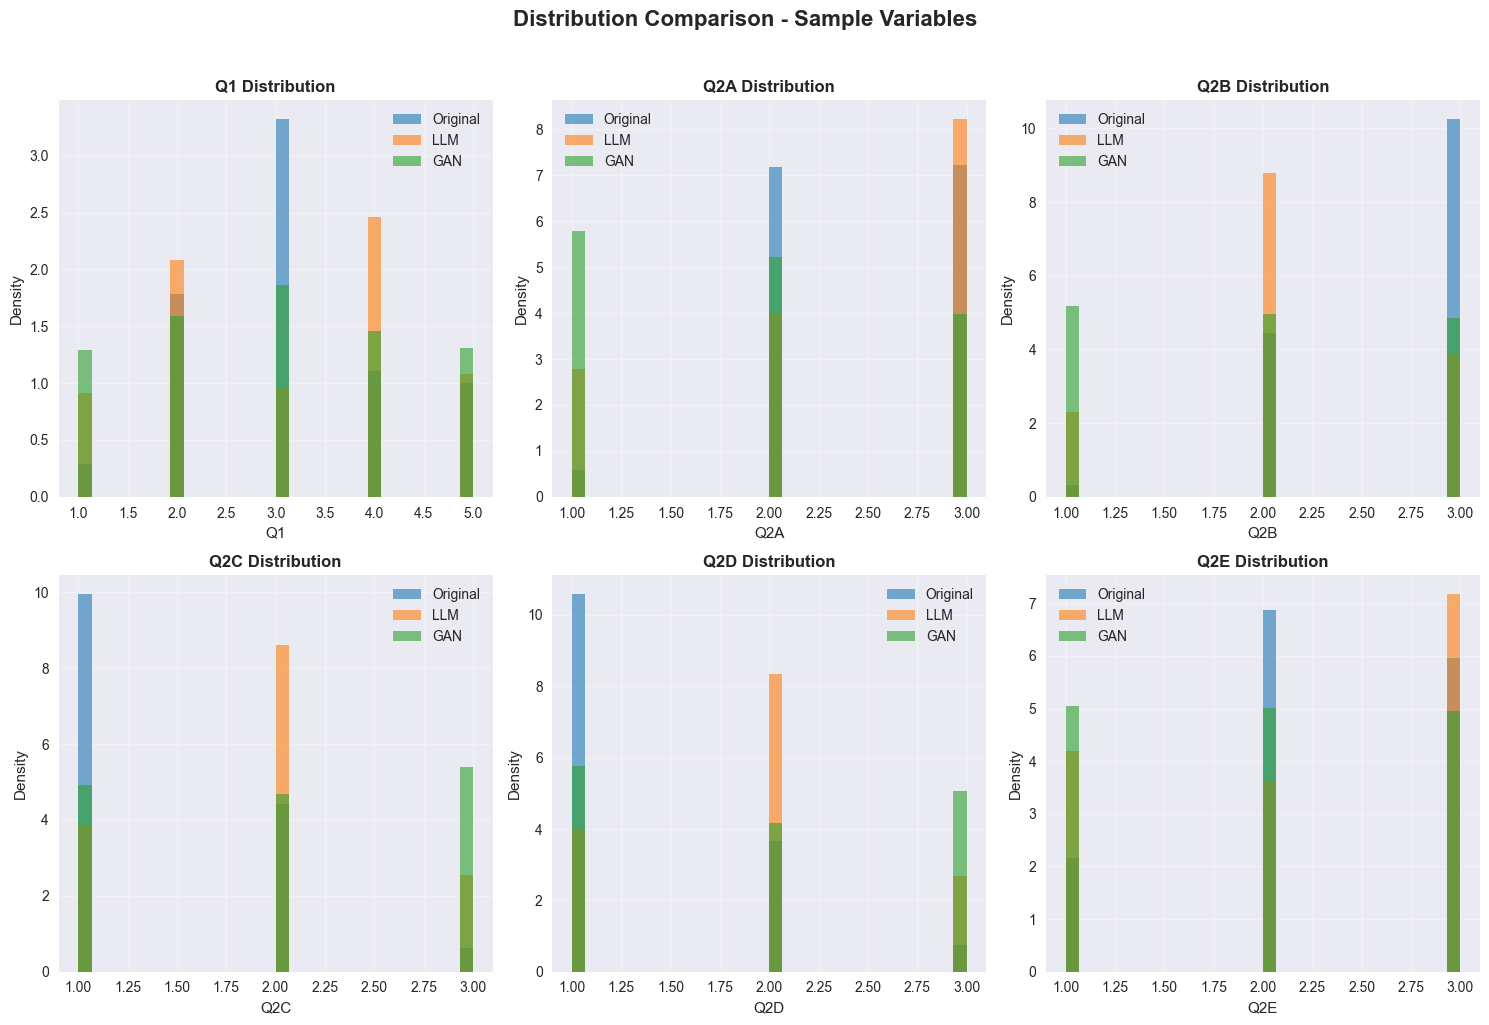

In [7]:
def plot_distribution_comparison(df_orig, df_llm, df_gan, columns, title_suffix=""):
    """Create comparative distribution plots"""
    
    n_cols = min(3, len(columns))
    n_rows = (len(columns) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
    
    for i, col in enumerate(columns):
        ax = axes[i]
        
        # Plot distributions
        if col in df_orig.columns:
            df_orig[col].hist(alpha=0.6, bins=30, density=True, 
                            color=colors[0], label='Original', ax=ax)
        
        if col in df_llm.columns:
            df_llm[col].hist(alpha=0.6, bins=30, density=True, 
                           color=colors[1], label='LLM', ax=ax)
        
        if col in df_gan.columns:
            df_gan[col].hist(alpha=0.6, bins=30, density=True, 
                           color=colors[2], label='GAN', ax=ax)
        
        ax.set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
        ax.set_xlabel(col)
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(f'Distribution Comparison{title_suffix}', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Plot first 6 columns for comparison
numeric_cols = df_original.select_dtypes(include=[np.number]).columns.tolist()[:6]
plot_distribution_comparison(df_original, df_llm, df_gan, numeric_cols, " - Sample Variables")

## 4. Korrelationsstruktur-Erhaltung

### 4.1 Korrelationsmatrizen Vergleich

In [ ]:
def compare_correlation_matrices(df_orig, df_llm, df_gan, sample_size=20):
    """Compare correlation matrices between datasets"""
    
    # Get numeric columns and sample for visualization
    numeric_cols = df_orig.select_dtypes(include=[np.number]).columns.tolist()
    sample_cols = numeric_cols[:sample_size]  # Take first N columns for cleaner visualization
    
    # Calculate correlation matrices
    corr_orig = df_orig[sample_cols].corr()
    corr_llm = df_llm[sample_cols].corr()
    corr_gan = df_gan[sample_cols].corr()
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Original
    sns.heatmap(corr_orig, annot=False, cmap='RdBu_r', center=0, 
                square=True, ax=axes[0,0], cbar_kws={'shrink': 0.8})
    axes[0,0].set_title('Original Data Correlations', fontsize=14, fontweight='bold')
    
    # LLM
    sns.heatmap(corr_llm, annot=False, cmap='RdBu_r', center=0, 
                square=True, ax=axes[0,1], cbar_kws={'shrink': 0.8})
    axes[0,1].set_title('LLM Synthetic Correlations', fontsize=14, fontweight='bold')
    
    # GAN
    sns.heatmap(corr_gan, annot=False, cmap='RdBu_r', center=0, 
                square=True, ax=axes[1,0], cbar_kws={'shrink': 0.8})
    axes[1,0].set_title('GAN Synthetic Correlations', fontsize=14, fontweight='bold')
    
    # Difference plot (Original - LLM)
    diff_llm = corr_orig - corr_llm
    sns.heatmap(diff_llm, annot=False, cmap='RdBu_r', center=0, 
                square=True, ax=axes[1,1], cbar_kws={'shrink': 0.8})
    axes[1,1].set_title('Correlation Difference (Original - LLM)', fontsize=14, fontweight='bold')
    
    plt.suptitle('Correlation Structure Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation preservation metrics
    # Flatten upper triangular matrices (excluding diagonal)
    mask = np.triu(np.ones_like(corr_orig, dtype=bool), k=1)
    
    orig_values = corr_orig.values[mask]
    llm_values = corr_llm.values[mask]
    gan_values = corr_gan.values[mask]
    
    # Calculate correlation between correlation matrices
    corr_preservation_llm = np.corrcoef(orig_values, llm_values)[0,1]
    corr_preservation_gan = np.corrcoef(orig_values, gan_values)[0,1]
    
    # Mean absolute difference
    mad_llm = np.mean(np.abs(orig_values - llm_values))
    mad_gan = np.mean(np.abs(orig_values - gan_values))
    
    print("\n📊 Correlation Preservation Metrics")
    print("=" * 40)
    print(f"LLM Correlation Preservation: {corr_preservation_llm:.4f}")
    print(f"GAN Correlation Preservation: {corr_preservation_gan:.4f}")
    print(f"\nLLM Mean Absolute Difference: {mad_llm:.4f}")
    print(f"GAN Mean Absolute Difference: {mad_gan:.4f}")
    
    return {
        'corr_orig': corr_orig,
        'corr_llm': corr_llm,
        'corr_gan': corr_gan,
        'preservation_llm': corr_preservation_llm,
        'preservation_gan': corr_preservation_gan,
        'mad_llm': mad_llm,
        'mad_gan': mad_gan
    }

# Run correlation comparison
correlation_results = compare_correlation_matrices(df_original, df_llm, df_gan)

## 5. Principal Component Analysis - Strukturerhaltung

In [ ]:
def compare_pca_structure(df_orig, df_llm, df_gan, n_components=10):
    """Compare PCA structure across datasets"""
    
    # Get numeric columns
    numeric_cols = df_orig.select_dtypes(include=[np.number]).columns.tolist()
    
    # Prepare data (remove NaN values)
    orig_clean = df_orig[numeric_cols].dropna()
    llm_clean = df_llm[numeric_cols].dropna()
    gan_clean = df_gan[numeric_cols].dropna()
    
    # Standardize data
    scaler = StandardScaler()
    
    orig_scaled = scaler.fit_transform(orig_clean)
    llm_scaled = scaler.transform(llm_clean)
    gan_scaled = scaler.transform(gan_clean)
    
    # Fit PCA on original data
    pca = PCA(n_components=n_components)
    pca.fit(orig_scaled)
    
    # Transform all datasets
    orig_pca = pca.transform(orig_scaled)
    llm_pca = pca.transform(llm_scaled)
    gan_pca = pca.transform(gan_scaled)
    
    # Plot explained variance
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Explained variance ratio
    axes[0].plot(range(1, n_components+1), pca.explained_variance_ratio_, 
                 marker='o', linewidth=2, markersize=8)
    axes[0].set_xlabel('Principal Component')
    axes[0].set_ylabel('Explained Variance Ratio')
    axes[0].set_title('PCA Explained Variance (Original Data)', fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Cumulative explained variance
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    axes[1].plot(range(1, n_components+1), cumvar, 
                 marker='o', linewidth=2, markersize=8, color='orange')
    axes[1].axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% Variance')
    axes[1].axhline(y=0.9, color='red', linestyle='--', alpha=0.7, label='90% Variance')
    axes[1].set_xlabel('Principal Component')
    axes[1].set_ylabel('Cumulative Explained Variance')
    axes[1].set_title('Cumulative Explained Variance', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot first two principal components comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    datasets = {
        'Original': orig_pca,
        'LLM Synthetic': llm_pca,
        'GAN Synthetic': gan_pca
    }
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for i, (name, data) in enumerate(datasets.items()):
        # Sample points for cleaner visualization
        sample_size = min(1000, len(data))
        sample_idx = np.random.choice(len(data), sample_size, replace=False)
        
        axes[i].scatter(data[sample_idx, 0], data[sample_idx, 1], 
                       alpha=0.6, color=colors[i], s=20)
        axes[i].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
        axes[i].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
        axes[i].set_title(f'{name} - PC Space', fontweight='bold')
        axes[i].grid(True, alpha=0.3)
    
    plt.suptitle('Principal Component Space Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Calculate structure preservation metrics
    variance_orig = np.var(orig_pca, axis=0)
    variance_llm = np.var(llm_pca, axis=0)
    variance_gan = np.var(gan_pca, axis=0)
    
    variance_corr_llm = np.corrcoef(variance_orig, variance_llm)[0,1]
    variance_corr_gan = np.corrcoef(variance_orig, variance_gan)[0,1]
    
    print("\n📊 PCA Structure Preservation")
    print("=" * 35)
    print(f"Components for 80% variance: {np.where(cumvar >= 0.8)[0][0] + 1}")
    print(f"Components for 90% variance: {np.where(cumvar >= 0.9)[0][0] + 1}")
    print(f"\nVariance Structure Correlation:")
    print(f"  LLM: {variance_corr_llm:.4f}")
    print(f"  GAN: {variance_corr_gan:.4f}")
    
    return {
        'pca': pca,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'cumulative_variance': cumvar,
        'variance_corr_llm': variance_corr_llm,
        'variance_corr_gan': variance_corr_gan
    }

# Run PCA comparison
pca_results = compare_pca_structure(df_original, df_llm, df_gan)

## 6. Qualitäts-Dashboard

### 6.1 Zusammenfassung der Evaluationsmetriken

In [ ]:
def create_quality_dashboard():
    """Create a comprehensive quality dashboard"""
    
    # Collect all metrics
    metrics = {
        'Dataset': ['LLM Synthetic', 'GAN Synthetic'],
        'Distribution Similarity (%)': [
            distribution_comparison['LLM_Similar'].mean() * 100,
            distribution_comparison['GAN_Similar'].mean() * 100
        ],
        'Correlation Preservation': [
            correlation_results['preservation_llm'],
            correlation_results['preservation_gan']
        ],
        'Correlation MAD': [
            correlation_results['mad_llm'],
            correlation_results['mad_gan']
        ],
        'PCA Variance Correlation': [
            pca_results['variance_corr_llm'],
            pca_results['variance_corr_gan']
        ]
    }
    
    dashboard_df = pd.DataFrame(metrics)
    
    # Round numerical values
    for col in dashboard_df.columns:
        if dashboard_df[col].dtype in ['float64', 'int64']:
            dashboard_df[col] = dashboard_df[col].round(4)
    
    print("🎯 Synthetic Data Quality Dashboard")
    print("=" * 45)
    display(dashboard_df)
    
    # Create radar chart for comparison
    fig = go.Figure()
    
    # Normalize metrics to 0-1 scale for radar chart
    metrics_normalized = {
        'Distribution Similarity': dashboard_df['Distribution Similarity (%)'].values / 100,
        'Correlation Preservation': dashboard_df['Correlation Preservation'].values,
        'Low Correlation Error': 1 - dashboard_df['Correlation MAD'].values,  # Invert so higher is better
        'PCA Structure': dashboard_df['PCA Variance Correlation'].values
    }
    
    categories = list(metrics_normalized.keys())
    
    # LLM trace
    llm_values = [metrics_normalized[cat][0] for cat in categories]
    llm_values += [llm_values[0]]  # Close the radar chart
    
    # GAN trace
    gan_values = [metrics_normalized[cat][1] for cat in categories]
    gan_values += [gan_values[0]]  # Close the radar chart
    
    categories_closed = categories + [categories[0]]
    
    fig.add_trace(go.Scatterpolar(
        r=llm_values,
        theta=categories_closed,
        fill='toself',
        name='LLM Synthetic',
        line_color='orange',
        fillcolor='rgba(255,127,14,0.3)'
    ))
    
    fig.add_trace(go.Scatterpolar(
        r=gan_values,
        theta=categories_closed,
        fill='toself',
        name='GAN Synthetic',
        line_color='green',
        fillcolor='rgba(44,160,44,0.3)'
    ))
    
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1]
            )),
        showlegend=True,
        title="Synthetic Data Quality Comparison",
        title_x=0.5,
        font_size=12
    )
    
    fig.show()
    
    return dashboard_df

# Create quality dashboard
quality_dashboard = create_quality_dashboard()

## 7. Preliminary Conclusions

### 7.1 Key Findings Summary

In [ ]:
def generate_summary_insights(dashboard_df):
    """Generate automated insights from the analysis"""
    
    llm_row = dashboard_df[dashboard_df['Dataset'] == 'LLM Synthetic'].iloc[0]
    gan_row = dashboard_df[dashboard_df['Dataset'] == 'GAN Synthetic'].iloc[0]
    
    print("🔍 Key Findings")
    print("=" * 20)
    
    # Distribution similarity
    if llm_row['Distribution Similarity (%)'] > gan_row['Distribution Similarity (%)']:
        better_dist = "LLM"
        dist_diff = llm_row['Distribution Similarity (%)'] - gan_row['Distribution Similarity (%)']
    else:
        better_dist = "GAN"
        dist_diff = gan_row['Distribution Similarity (%)'] - llm_row['Distribution Similarity (%)']
    
    print(f"📊 Distribution Preservation: {better_dist} performs better by {dist_diff:.1f} percentage points")
    
    # Correlation preservation
    if llm_row['Correlation Preservation'] > gan_row['Correlation Preservation']:
        better_corr = "LLM"
        corr_diff = llm_row['Correlation Preservation'] - gan_row['Correlation Preservation']
    else:
        better_corr = "GAN"
        corr_diff = gan_row['Correlation Preservation'] - llm_row['Correlation Preservation']
    
    print(f"🔗 Correlation Structure: {better_corr} preserves structure better (difference: {corr_diff:.3f})")
    
    # PCA structure
    if llm_row['PCA Variance Correlation'] > gan_row['PCA Variance Correlation']:
        better_pca = "LLM"
        pca_diff = llm_row['PCA Variance Correlation'] - gan_row['PCA Variance Correlation']
    else:
        better_pca = "GAN"
        pca_diff = gan_row['PCA Variance Correlation'] - llm_row['PCA Variance Correlation']
    
    print(f"🎯 PCA Structure: {better_pca} better preserves variance structure (difference: {pca_diff:.3f})")
    
    # Overall assessment
    llm_wins = sum([llm_row['Distribution Similarity (%)'] > gan_row['Distribution Similarity (%)'],
                   llm_row['Correlation Preservation'] > gan_row['Correlation Preservation'],
                   llm_row['PCA Variance Correlation'] > gan_row['PCA Variance Correlation']])
    
    print(f"\n🏆 Overall Performance: {'LLM wins' if llm_wins >= 2 else 'GAN wins'} on {max(llm_wins, 3-llm_wins)}/3 metrics")
    
    print("\n💡 Recommendations for Neural Network Training:")
    if llm_wins >= 2:
        print("   • Consider using LLM-generated data for initial model training")
        print("   • LLM data shows better statistical properties preservation")
    else:
        print("   • Consider using GAN-generated data for initial model training")
        print("   • GAN data shows better statistical properties preservation")
    
    print("   • Validate model performance on both synthetic datasets")
    print("   • Consider ensemble approaches using both generation methods")
    print("   • Monitor for potential overfitting to synthetic data characteristics")

# Generate summary insights
generate_summary_insights(quality_dashboard)

## Next Steps

### Planned Analysis Extensions:

1. **Deep Dive Categorical Analysis**: Detailed comparison of categorical variable distributions
2. **Cluster Analysis**: Comparison of customer segments across datasets
3. **Neural Network Readiness**: Specific metrics for ML model training
4. **Edge Case Analysis**: Handling of extreme values and outliers
5. **Domain-Specific Validation**: Beer preference logic and consistency checks

### Technical Improvements:
- Interactive visualizations for detailed exploration
- Automated report generation
- Statistical significance testing for all comparisons
- Performance benchmarking on actual ML tasks

---

*This analysis provides a foundation for evaluating synthetic data quality. Continue with domain-specific validations and ML performance testing.*